In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

In [3]:
import jax
import jax.numpy as jnp

from typing import Generator

from model import Model, ModelParameters
from model.training import Trainer

from model.hyperparameters import (
    dt,
    cortical_column_hyperparameters,
    sequence_model_hyperparameters,
    semantic_model_hyperparameters,
    training_model_hyperparameters,
    training_hyperparameters,
)

from patterns import collection1_fixed_dimensions, collection1_variable_dimensions, collection2

# Patterns

In [4]:
def display_pattern(ax, pattern, animated=False):
    """Draw the specified pattern on a matplotlib axes."""
    return ax.imshow(pattern.reshape((20, 20)), cmap="Greys", vmin=0, vmax=1, animated=animated)

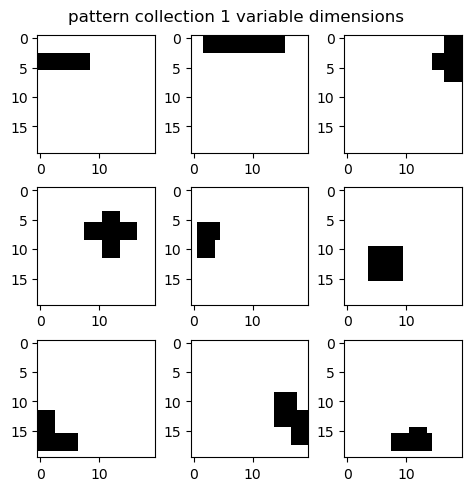

In [5]:
fig, axs = plt.subplots(3, 3, layout="compressed")
for ax, pattern in zip(axs.flat, collection1_variable_dimensions):
    display_pattern(ax, pattern)
fig.suptitle("pattern collection 1 variable dimensions")
plt.show()

In [6]:
def corrupt_pattern(key: jax.Array, pattern: jax.Array, fraction: float):
    """Remove random pixels from the given pattern, leaving a fraction behind."""
    indices = jnp.flatnonzero(pattern)
    new_indices = jax.random.choice(key, indices, (int(fraction * indices.size),), replace=False)
    new_pattern = jnp.zeros((pattern.size,)).at[new_indices].set(1).reshape(pattern.shape)
    return new_pattern

In [7]:
key = jax.random.key(0)
keys = jax.random.split(key, len(collection1_variable_dimensions))
collection1_variable_dimensions_incomplete = [corrupt_pattern(key, pattern, 0.7) for key, pattern in zip(keys, collection1_variable_dimensions)]

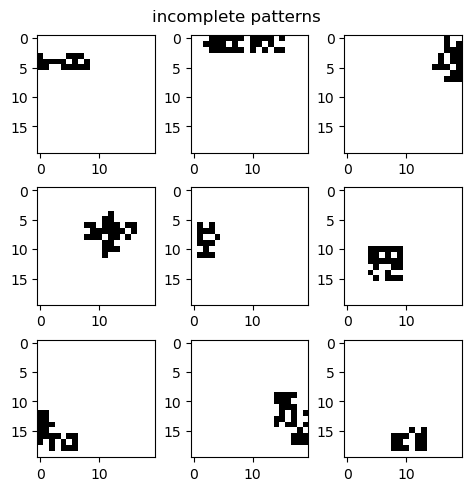

In [8]:
fig, axs = plt.subplots(3, 3, layout="compressed")
for ax, pattern in zip(axs.flat, collection1_variable_dimensions_incomplete):
    display_pattern(ax, pattern)
fig.suptitle("incomplete patterns")
plt.show()

# Training

In [9]:
def train_phase_1(
    key: jax.Array,
    trainer: Trainer,
    model: Model,
    params: ModelParameters,
    collection: jax.Array,
) -> ModelParameters:
    """Phase 1 of training. """
    with tqdm(total=len(collection) * 2500) as pbar:
        for pattern in collection:
            # initialize state
            state = Model.init_state((400,))
            # excitatory inputs
            excitatory_inputs = 2000 * jnp.array([
                jnp.zeros((400,)),
                pattern,
                pattern,
                pattern,
            ])
            # inhibitory inputs
            inhibitory_inputs = 2000 * jnp.array([
                jnp.zeros((400,)),
                jnp.zeros((400,)),
                pattern,
                pattern,
            ])

            wm_maintenance = jnp.zeros((400,))
            for i in range(2500):
                key, new_key = jax.random.split(key)
                # add input noise
                ei, ii = model.add_input_noise(new_key, excitatory_inputs, inhibitory_inputs)
                # simulate model
                state, pfr, fifr = model(state, params, ei, ii, wm_maintenance)
                if i > 500:
                    # update parameters
                    params = trainer.step1(params, pfr, fifr)
                pbar.update(1)

            # plot pyramidal activity
            # fig, axs = plt.subplots(1, 4)
            # for ax, p in zip(axs.flat, pfr):
            #     display_pattern(ax, p / 5)
            # plt.show()
    params = trainer.normalize(params)
    return params

In [10]:
def train_phase_2(
    key: jax.Array,
    trainer: Trainer,
    model: Model,
    params: ModelParameters,
    collection: jax.Array,
) -> ModelParameters:
    """Phase 2 of training."""
    with tqdm(total=(len(collection) - 1) * 1500) as pbar:
        for pattern1, pattern2 in zip(collection, collection[1:]):
            # initialize state
            state = Model.init_state((400,))
            # excitatory inputs
            excitatory_inputs = 2700 * jnp.array([
                jnp.zeros((400,)),
                jnp.zeros((400,)),
                pattern2,
                pattern1,
            ])
            # inhibitory inputs
            inhibitory_inputs = jnp.zeros((4, 400))
            wm_maintenance = jnp.zeros((400,))

            for i in range(1500):
                key, new_key = jax.random.split(key)
                # add input noise
                ei, ii = model.add_input_noise(new_key, excitatory_inputs, inhibitory_inputs)
                # simulate model
                state, pfr, _ = model(state, params, ei, ii, wm_maintenance)
                if i > 500:
                    # update parameters
                    params = trainer.step2(params, pfr)
                pbar.update(1)

            # plot pyramidal activity
            # fig, axs = plt.subplots(1, 4)
            # for ax, p in zip(axs.flat, pfr):
            #     display_pattern(ax, p / 5)
            # plt.show()
    return params

In [11]:
trainer = Trainer(training_hyperparameters)
training_model = Model(cortical_column_hyperparameters, training_model_hyperparameters, dt)

In [12]:
key = jax.random.key(1)
key1, key2 = jax.random.split(key)
params = Model.init_params((400,))
params = train_phase_1(key1, trainer, training_model, params, collection1_variable_dimensions)

  0%|          | 0/22500 [00:00<?, ?it/s]

In [13]:
params = train_phase_2(key2, trainer, training_model, params, collection1_variable_dimensions)

  0%|          | 0/12000 [00:00<?, ?it/s]

# Simulations

In [14]:
def simulate_model(
    model: Model,
    params: ModelParameters,
    excitatory_inputs: jax.Array,
    inhibitory_inputs: jax.Array,
    wm_maintenance_signal: jax.Array,
) -> Generator[jax.Array, None, None]:
    """Simulate a given model."""
    state = Model.init_state((400,))
    for ei, ii, wm_maintenance in zip(excitatory_inputs, inhibitory_inputs, wm_maintenance_signal):
        state, pfr, _ = model(state, params, ei, ii, wm_maintenance)
        yield pfr

In [15]:
def single_input_presentation(pattern: jax.Array, duration: int) -> jax.Array:
    """Return an array of inputs corresponding to a single presentation of a pattern."""
    zeros = jnp.zeros((duration, 4, 400))
    # present pattern to layer WM from time 0.005 to 0.055
    excitatory_inputs = 400 * zeros.at[50:550, 0].set(pattern)

    return excitatory_inputs

In [16]:
def generate_wm_maintenance_signal(input_patterns: list[jax.Array], duration: int) -> jax.Array:
    """Generate wm maintenance signal based on input patterns."""
    wm_maintenance_signal = jnp.zeros((len(input_patterns) * duration, 400))
    for i, pattern in enumerate(input_patterns):
        # maintenance signal is active from the end of the current input presentation to the start of the next input presentation
        wm_maintenance_signal = wm_maintenance_signal.at[i * duration + 550 : (i + 1) * duration + 50].set(pattern)
    return wm_maintenance_signal

In [17]:
# initialize models
semantic_wm_model = Model(cortical_column_hyperparameters, semantic_model_hyperparameters, dt)
sequence_wm_model = Model(cortical_column_hyperparameters, sequence_model_hyperparameters, dt)

## Simulation 1: WM and L1

In [18]:
T = 0.4
num_patterns = 2
n = round(T / dt)
N = n * num_patterns
key = jax.random.key(2)

patterns = collection1_variable_dimensions[:num_patterns]
incomplete_patterns = collection1_variable_dimensions_incomplete[:num_patterns]

# present patterns with T seconds in between
pre_noise_excitatory_inputs = jnp.concatenate([single_input_presentation(pattern, n) for pattern in incomplete_patterns])
# inhibitory inputs are zero
pre_noise_inhibitory_inputs = jnp.zeros_like(pre_noise_excitatory_inputs)
# maintenance signal is zero when our inputs are active, and matches our input when our inputs are inactive
wm_maintenance_signal = generate_wm_maintenance_signal(incomplete_patterns, n)
# add noise
excitatory_inputs, inhibitory_inputs = semantic_wm_model.add_input_noise(key, pre_noise_excitatory_inputs, pre_noise_inhibitory_inputs)


t = jnp.arange(0, num_patterns * T, dt)
pfr = jnp.array(list(tqdm(simulate_model(sequence_wm_model, params, excitatory_inputs, inhibitory_inputs, wm_maintenance_signal), total=num_patterns*n)))

  0%|          | 0/8000 [00:00<?, ?it/s]

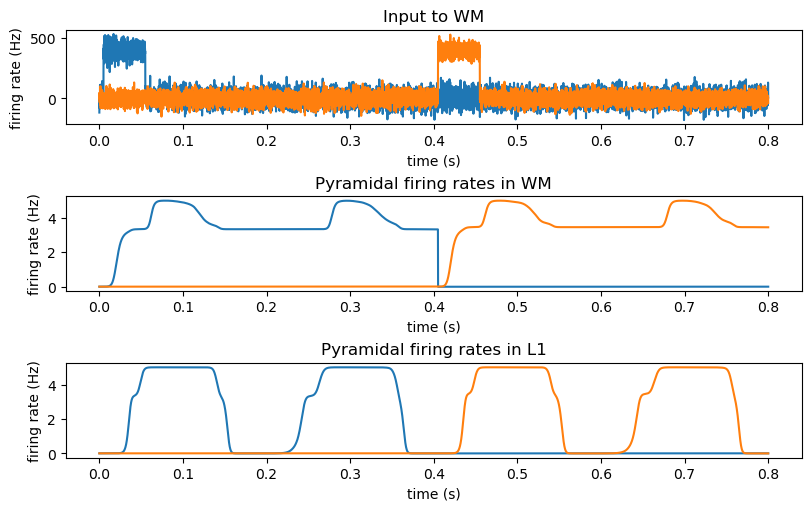

In [19]:
fig, (ax_in, ax_wm, ax_l1) = plt.subplots(3, figsize=(8, 5), layout="compressed")

for pattern, incomplete_pattern in zip(patterns, incomplete_patterns):
    ax_in.plot(t, jnp.sum(excitatory_inputs[:, 0] * incomplete_pattern, axis=1) / jnp.sum(incomplete_pattern)), 
    ax_wm.plot(t, jnp.sum(pfr[:, 0] * pattern, axis=1) / jnp.sum(pattern))
    ax_l1.plot(t, jnp.sum(pfr[:, 1] * pattern, axis=1) / jnp.sum(pattern))

ax_in.set_title("Input to WM")
ax_in.set_xlabel("time (s)")
ax_in.set_ylabel("firing rate (Hz)")

ax_wm.set_title("Pyramidal firing rates in WM")
ax_wm.set_xlabel("time (s)")
ax_wm.set_ylabel("firing rate (Hz)")

ax_l1.set_title("Pyramidal firing rates in L1")
ax_l1.set_xlabel("time (s)")
ax_l1.set_ylabel("firing rate (Hz)")

plt.show()
fig.savefig("wm_l1.png")

## Simulation 2: Sequence Working Memory

In [20]:
T = 0.6
num_patterns = 3
n = round(T / dt)
N = n * num_patterns
key = jax.random.key(3)

patterns = collection1_variable_dimensions[:num_patterns]
incomplete_patterns = collection1_variable_dimensions_incomplete[:num_patterns]

# present patterns with T seconds in between
pre_noise_excitatory_inputs = jnp.concatenate([single_input_presentation(pattern, n) for pattern in incomplete_patterns])
# inhibitory inputs are zero
pre_noise_inhibitory_inputs = jnp.zeros_like(pre_noise_excitatory_inputs)
# maintenance signal is zero when our inputs are active, and matches our input when our inputs are inactive
wm_maintenance_signal = generate_wm_maintenance_signal(incomplete_patterns, n)
# add noise
excitatory_inputs, inhibitory_inputs = semantic_wm_model.add_input_noise(key, pre_noise_excitatory_inputs, pre_noise_inhibitory_inputs)


t = jnp.arange(0, num_patterns * T, dt)
pfr = jnp.array(list(tqdm(simulate_model(sequence_wm_model, params, excitatory_inputs, inhibitory_inputs, wm_maintenance_signal), total=num_patterns*n)))

  0%|          | 0/18000 [00:00<?, ?it/s]

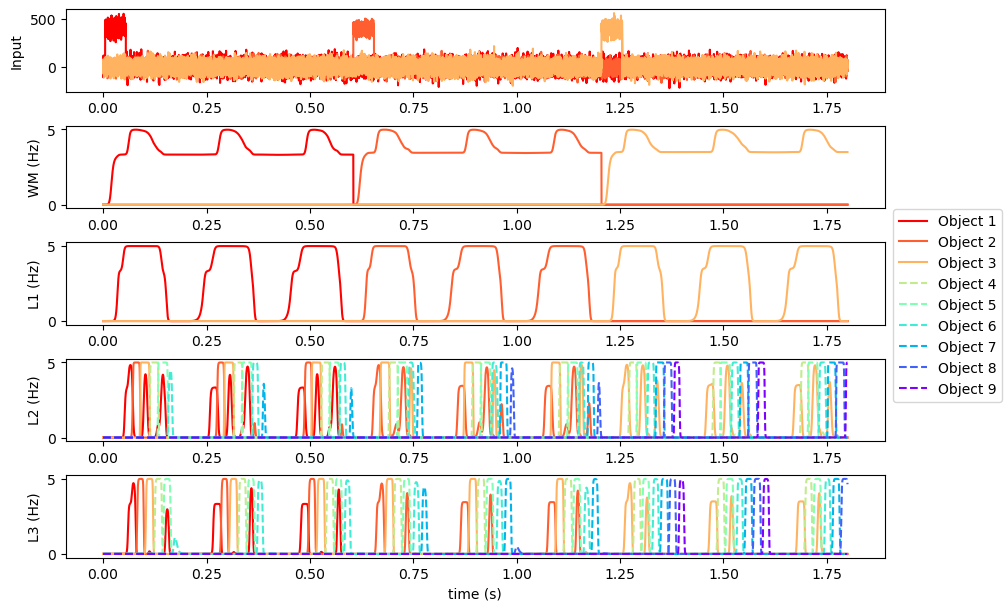

In [21]:
fig, (ax_in, *ax_layers) = plt.subplots(5, figsize=(10, 6), layout="compressed")

for ax in ax_in, *ax_layers:
    ax.set_prop_cycle(color=plt.get_cmap("rainbow")(jnp.linspace(1, 0, 9)))

for pattern, incomplete_pattern in zip(patterns, incomplete_patterns):
    # input plot
    ax_in.plot(t, jnp.sum(excitatory_inputs[:, 0] * incomplete_pattern, axis=1) / jnp.sum(incomplete_pattern))
    # layer plots solid lines
    for layer, ax in enumerate(ax_layers):
        ax.plot(t, jnp.sum(pfr[:, layer] * pattern, axis=1) / jnp.sum(pattern))

for pattern in collection1_variable_dimensions[num_patterns:]:
    # layer plots dotted lines
    for layer, ax in list(enumerate(ax_layers))[2:]:
        ax.plot(t, jnp.sum(pfr[:, layer] * pattern, axis=1) / jnp.sum(pattern), linestyle='dashed')

ax_in.set_ylabel("Input")

for ax, layer_name in zip(ax_layers, ["WM", "L1", "L2", "L3"]):
    ax.set_ylabel(f"{layer_name} (Hz)")

ax_layers[3].set_xlabel("time (s)")

handles = ax_layers[3].lines
labels = [f"Object {i + 1}" for i in range(len(collection1_variable_dimensions))]
fig.legend(handles, labels, loc="outside center right")

plt.show()
fig.savefig("sequence_wm.png")

In [22]:
def animate_model(scale: float):
    """Animate the model with speed set by scale."""
    fps = 60
    # frame interval in ms
    interval = round(1000 / fps)
    # timesteps
    step = interval / 1000 / dt * scale
    frames = jnp.round(jnp.arange(0, N, step))
    
    fig, axs = plt.subplots(1, 5, figsize=(10, 3), layout="compressed")
    
    fig.suptitle("Pyramidal activity of each cortical column")
    axs[0].set_title("Input")
    axs[1].set_title("WM")
    axs[2].set_title("L1")
    axs[3].set_title("L2")
    axs[4].set_title("L3")
    
    ims = [display_pattern(ax, jnp.zeros((400)), animated=True) for ax in axs]
    
    
    def updatefig(timestep):
        ims[0].set_array(pre_noise_excitatory_inputs[round(timestep), 0].reshape((20, 20)) / 400)
        for layer, im in enumerate(ims[1:]):
            im.set_array(pfr[round(timestep), layer].reshape((20, 20)) / 5)
        return ims
    
    anim = animation.FuncAnimation(fig, updatefig, frames=tqdm(frames), interval=interval, blit=True)
    writer = animation.FFMpegWriter(fps=fps)
    video = anim.to_html5_video()
    html = display.HTML(video) 
    display.display(html)
    plt.close()

    return anim, writer

In [23]:
# realtime animation
sequence_realtime_animation, writer = animate_model(1)

  0%|          | 0/106 [00:00<?, ?it/s]

In [24]:
sequence_realtime_animation.save("sequence_realtime.mp4", writer=writer)

In [25]:
# 10 times slowed down animation
sequence_10x_slow_animation, writer = animate_model(1/10)

  0%|          | 0/1059 [00:00<?, ?it/s]

In [26]:
sequence_10x_slow_animation.save("sequence_10x_slow.mp4", writer=writer)

## Simulation 3: Semantic Working Memory

In [27]:
T = 0.5
num_patterns = 4
n = round(T / dt)
N = n
key = jax.random.key(4)

patterns = collection1_variable_dimensions[:num_patterns]
incomplete_patterns = collection1_variable_dimensions_incomplete[:num_patterns]
combined_pattern = sum(incomplete_patterns)

# present all patterns together once
pre_noise_excitatory_inputs = single_input_presentation(combined_pattern, n)
# inhibitory inputs are zero
pre_noise_inhibitory_inputs = jnp.zeros_like(pre_noise_excitatory_inputs)
# maintenance signal is zero when our inputs are active, and matches our input when our inputs are inactive
wm_maintenance_signal = generate_wm_maintenance_signal([combined_pattern], n)
# add noise
excitatory_inputs, inhibitory_inputs = semantic_wm_model.add_input_noise(key, pre_noise_excitatory_inputs, pre_noise_inhibitory_inputs)


t = jnp.arange(0, T, dt)
pfr = jnp.array(list(tqdm(simulate_model(semantic_wm_model, params._replace(w_l2_l3=jnp.zeros((400,))), excitatory_inputs, inhibitory_inputs, wm_maintenance_signal), total=n)))

  0%|          | 0/5000 [00:00<?, ?it/s]

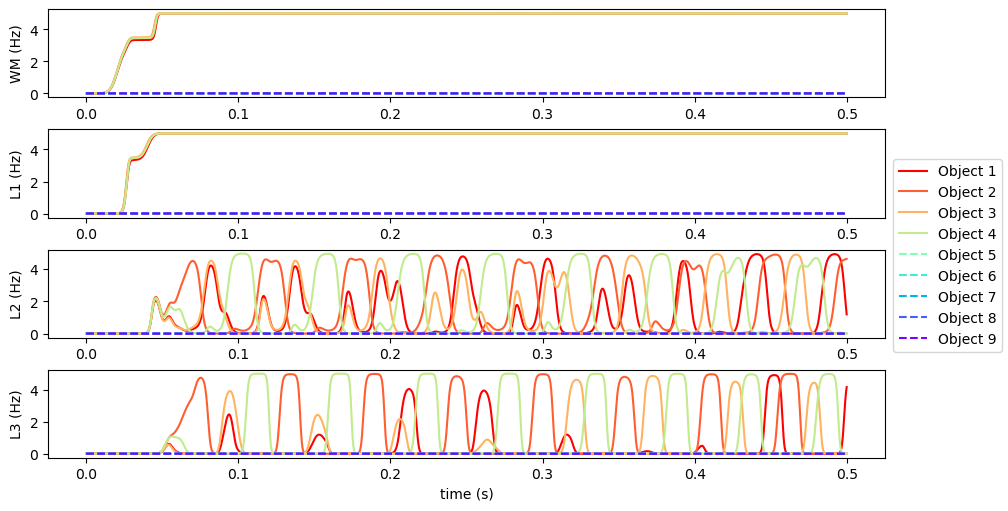

In [28]:
fig, ax_layers = plt.subplots(4, figsize=(10, 5), layout="compressed")

for ax in ax_layers:
    ax.set_prop_cycle(color=plt.get_cmap("rainbow")(jnp.linspace(1, 0, 9)))

for pattern in patterns:
    # layer plots solid lines
    for layer, ax in enumerate(ax_layers):
        ax.plot(t, jnp.sum(pfr[:, layer] * pattern, axis=1) / jnp.sum(pattern))

for pattern in collection1_variable_dimensions[num_patterns:]:
    # layer plots dotted lines
    for layer, ax in list(enumerate(ax_layers)):
        ax.plot(t, jnp.sum(pfr[:, layer] * pattern, axis=1) / jnp.sum(pattern), linestyle='dashed')

for ax, layer_name in zip(ax_layers, ["WM", "L1", "L2", "L3"]):
    ax.set_ylabel(f"{layer_name} (Hz)")

ax_layers[3].set_xlabel("time (s)")

handles = ax_layers[3].lines
labels = [f"Object {i + 1}" for i in range(len(collection1_variable_dimensions))]
fig.legend(handles, labels, loc="outside center right")

plt.show()
fig.savefig("semantic_wm.png")